# GPU Configuration

In [1]:
!nvidia-smi

Sun Nov 20 08:12:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Packages

In [2]:
# Common Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from google.colab import drive
from matplotlib.image import imread

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchsummary import summary as Summary
from torch.utils.data import Dataset, DataLoader, random_split

# Mounting Google Drive

In [3]:
if not os.path.isdir("/content/Network_Data"):

    if not os.path.isdir("/content/Drive"):

        drive.mount("Drive")

    !unzip -qq /content/Drive/MyDrive/Thesis/Classifier/Network_Data.zip

#Functions

In [4]:
def weight_initializer(module):

    if isinstance(module, nn.Conv2d):
        nn.init.xavier_normal_(module.weight, 0.2)
        nn.init.constant_(module.bias, 0.001)

    elif isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight, 0.2)
        nn.init.constant_(module.bias, 0.001)

In [5]:
def Accuracy_Computer(Model, Dataset, Device):

    Corrects = 0
    Samples = 0
    Model.eval()

    with torch.no_grad():

        for image, label in Dataset:
            
            # Transfer Data to GPU
            image = image.to(device=Device)
            label = label.to(device=Device)

            # forward(prediction)
            label_prime = Model(image)
            _, predictions = label_prime.max(1)

            # determine the correct samples
            Corrects += (predictions == label).sum()
            Samples += label.shape[0]

        Accuracy =  Corrects / Samples

    return float(Accuracy)

# Classes

In [6]:
class CNN_Model(nn.Module):
     
    def __init__(self, Input_Size, Number_of_Classes=2):
        
        super().__init__()
        Input_Channels = Input_Size[0]

        # Temp_X = torch.zeros(Input_Size)
        Temp_X = torch.reshape(torch.zeros(Input_Size), (1, *Input_Size))

        # Convolutional Layers
        self.Conv_Network = nn.Sequential(
            
            # First Layer
            nn.Conv2d(Input_Channels, 96, 7, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second Layer
            nn.Conv2d(96, 32, 5, 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Third Layer
            nn.Conv2d(32, 16, 3, 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Fourth Layer
            nn.Conv2d(16, 8, 3, 2),
            nn.ReLU(inplace=True),
            nn.Flatten()
        )

        First_Layer_Size = self.Conv_Network(Temp_X).shape[1]

        # Linear Layers
        self.Linear_Network = nn.Sequential(
            # Fifth Layer
            nn.Linear(First_Layer_Size, 50),
            nn.ReLU(inplace=True),

            # Sixth Layer
            nn.Linear(50, 32),
            nn.ReLU(inplace=True),

            # Seventh Layer
            nn.Linear(32, Number_of_Classes),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):

        return self.Linear_Network(self.Conv_Network(x))

In [7]:
class Medical_Dataset(Dataset):

    def __init__(self, root_folder, class_folder, XTransformer=None, YTransformer=None):
        
        self.XTransformer = XTransformer
        self.YTransformer = YTransformer

        Total_Images = np.empty(0)
        Total_Labels = np.empty(0)

        # loop through each folder
        for index, folder in enumerate(class_folder):

            folder_path = os.path.join(root_folder, folder)

            # loop through each sample
            for image_name in os.listdir(folder_path):
                
                Total_Images = np.append(Total_Images, os.path.join(folder_path, image_name))
                Total_Labels = np.append(Total_Labels, index)

        permutation = np.random.permutation(np.arange(len(Total_Images)))
        
        self.images = Total_Images[permutation]
        self.labels = torch.from_numpy(Total_Labels[permutation]).type(torch.LongTensor)
        
    def __len__(self):

        return self.images.shape[0]

    def __getitem__(self, index):

        # Retriving Indexed Image
        image_path = self.images[index]
        image = imread(image_path)

        if self.XTransformer:
            
            image = self.XTransformer(image)

        # Retriving Indexed Label
        label = self.labels[index]

        if self.YTransformer:
            
            label = self.YTransformer(label)
        
        return image, label

In [8]:
class ToNumpy():

    def __call__(self, input):

        return np.array(input)

# Training Specs

In [9]:
Epochs = 60
Batch_Size = 75
Train_Split = 0.9
Learning_Rate = 1e-4
Learning_Rate_Factor = 20
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Defining Dataset

In [10]:
Composit_Transformer = transforms.Compose([ToNumpy(), transforms.ToTensor()])

Full_Dataset = Medical_Dataset("/content/Network_Data", ["Preictal_Data", "Interictal_Data"], XTransformer=Composit_Transformer)

Train_size = int(len(Full_Dataset) * Train_Split)
Test_size = len(Full_Dataset) - Train_size
Train_Dataset, Test_Dataset = random_split(Full_Dataset, [Train_size, Test_size])

Train_Loader = DataLoader(dataset=Train_Dataset, batch_size=Batch_Size, shuffle=True, pin_memory=True, num_workers=2)
Test_Loader = DataLoader(dataset=Test_Dataset,batch_size=Batch_Size, shuffle=True, pin_memory=True, num_workers=2)

image , _ = Train_Dataset.__getitem__(0)
input_size = tuple(image.shape)
print(input_size)

(3, 256, 256)



# Defining Model

In [11]:
Model = CNN_Model(input_size, 2).to(Device)
Model.apply(weight_initializer)
Summary(Model, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 125, 125]          14,208
              ReLU-2         [-1, 96, 125, 125]               0
         MaxPool2d-3           [-1, 96, 62, 62]               0
            Conv2d-4           [-1, 32, 29, 29]          76,832
              ReLU-5           [-1, 32, 29, 29]               0
           Dropout-6           [-1, 32, 29, 29]               0
            Conv2d-7           [-1, 16, 14, 14]           4,624
              ReLU-8           [-1, 16, 14, 14]               0
         MaxPool2d-9             [-1, 16, 7, 7]               0
           Conv2d-10              [-1, 8, 3, 3]           1,160
             ReLU-11              [-1, 8, 3, 3]               0
          Flatten-12                   [-1, 72]               0
           Linear-13                   [-1, 50]           3,650
             ReLU-14                   

In [12]:
Criteria = nn.CrossEntropyLoss()
Optimizer = optim.Adam(Model.parameters(), lr= Learning_Rate * Learning_Rate_Factor)

In [13]:
Total_Train_Accuracy = list()
Total_Test_Accuracy = list()

Total_Train_Loss = list()
Total_Test_Loss = list()

for epoch in range(1, Epochs + 1):

    Unormalized_Train_Loss = 0
    Unormalized_Test_Loss = 0

    for Batch_Number, (image, label) in enumerate(Train_Loader):
        
        image = image.to(device=Device)
        label = label.to(device=Device)

        # zero the parameter gradient
        Optimizer.zero_grad()

        # Forward Step
        ouput = Model(image)

        # Backward Step
        Loss = Criteria(ouput, label)
        Loss.backward()


        # Opimization Step
        Optimizer.step()

        # Calculating the Loss in an epoch
        Unormalized_Train_Loss += Loss.item()

    Train_Loss = Unormalized_Train_Loss / Batch_Number
    Total_Train_Loss.append(Train_Loss)

    # Calculating the Test Loss
    with torch.no_grad():

        for Batch_Number, (image, label) in enumerate(Test_Loader):

            # # Transfer data to Device
            label = label.to(Device)
            image = image.to(Device)

            # Forward Propagation and Calculate the Loss
            output = Model(image)
            Loss = Criteria(output, label)

            # Calculating loss for all the Test Dataset
            Unormalized_Test_Loss += Loss.item()

    Test_Loss = Unormalized_Test_Loss / Batch_Number
    Total_Test_Loss.append(Test_Loss)

    Train_Accuracy =  Accuracy_Computer(Model, Train_Loader, Device)
    Test_Accuracy = Accuracy_Computer(Model, Test_Loader, Device)
    
    Total_Train_Accuracy.append(Train_Accuracy)
    Total_Test_Accuracy.append(Test_Accuracy)

    print(f"Epoch {epoch}/{Epochs} :\n {' ' * 5} "
          f"[Train Loss = {Train_Loss:.5f}] - [Train Accuracy = {(Train_Accuracy * 100):.2f}%] | "
          f"[Test Loss = {Test_Loss:.5f}] - [Test Accuracy = {(Test_Accuracy * 100):.2f}%] \n "
          f"{' ' * 4 + '-' * 110}")

Epoch 1/60 :
       [Train Loss = 0.70207] - [Train Accuracy = 50.05%] | [Test Loss = 0.77953] - [Test Accuracy = 49.55%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 2/60 :
       [Train Loss = 0.68438] - [Train Accuracy = 50.05%] | [Test Loss = 0.73119] - [Test Accuracy = 49.55%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 3/60 :
       [Train Loss = 0.64055] - [Train Accuracy = 64.92%] | [Test Loss = 0.71812] - [Test Accuracy = 64.24%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 4/60 :
       [Train Loss = 0.63313] - [Train Accuracy = 68.79%] | [Test Loss = 0.69023] - [Test Accuracy = 67.88%] 
     --------------------------------------------------------------------------------------------------------------
Epoch 5/60 :
       [Train Loss = 0.61044] -

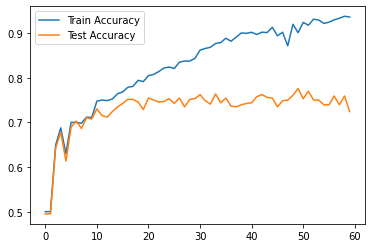

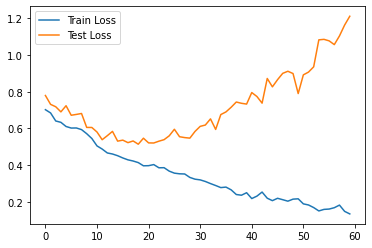

In [14]:
plt.plot(Total_Train_Accuracy)
plt.plot(Total_Test_Accuracy)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

plt.plot(Total_Train_Loss)
plt.plot(Total_Test_Loss)
plt.legend(["Train Loss", "Test Loss"])
plt.show()